In [1]:
import pandas as pd
import numpy as np
import joblib as jb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from satellite_bathymetry.preprocessing import get_coord_from_pixel_pos, get_pixel_from_coord, ndwi, pixel_ndwi, pixel_log_ratio
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

In [2]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.cluster import KMeans

In [7]:
sns.set_style('darkgrid')

In [3]:
path = './generated/dataset_dataframe.pkl.z'
df = jb.load(path)
df.head()

,x,y,z,b1,b2,b3,b4,b5,b6,b7,b8,cspmb7,b2b4,b3b4,ndwi15,ndwi24,ndwi53
0,233,1130,3.195862,0.1199,0.0887,0.0692,0.0483,0.0518,0.0328,0.0315,0.0252,27.041417,1.156761,1.092734,0.396622,0.294890,-0.143802
1,233,1131,3.273030,0.1199,0.0886,0.0691,0.0484,0.0519,0.0335,0.0317,0.0254,27.274666,1.155853,1.091779,0.395809,0.293431,-0.142149
2,233,1132,3.299687,0.1199,0.0886,0.0690,0.0485,0.0519,0.0336,0.0320,0.0255,27.625527,1.155238,1.090825,0.395809,0.292487,-0.141439
3,233,1133,3.268182,0.1199,0.0885,0.0689,0.0484,0.0518,0.0336,0.0321,0.0256,27.742739,1.155562,1.091031,0.396622,0.292915,-0.141674
4,233,1134,3.278125,0.1199,0.0884,0.0688,0.0482,0.0517,0.0336,0.0321,0.0257,27.742739,1.156505,1.091822,0.397436,0.294290,-0.141909


# Random Split Data

In [4]:
columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']
#bands_cspm_features = df[['b1', 'b5', 'b6', 'cspmb7']]
#bands_cspm_target = df.z

X_train, X_val, y_train, y_val = train_test_split(df[columns], df.z, test_size=0.3, random_state=42)

# 1.0 - Random Forest

In [5]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
p_rf = rf.predict(X_val)
print('RF Bands:')
print('R2 score:', r2_score(y_val, p_rf))
print('MAE:', mean_absolute_error(y_val, p_rf))
print('MSE:', mean_squared_error(y_val, p_rf))
print('RMSE:', np.sqrt(mean_squared_error(y_val, p_rf)))
print('Bias:', p_rf.mean() - y_val.mean())

RF Bands:
R2 score: 0.9431292533469585
MAE: 0.5466923361294626
MSE: 1.1473108298873484
RMSE: 1.0711259635950146
Bias: 0.0341566515332703


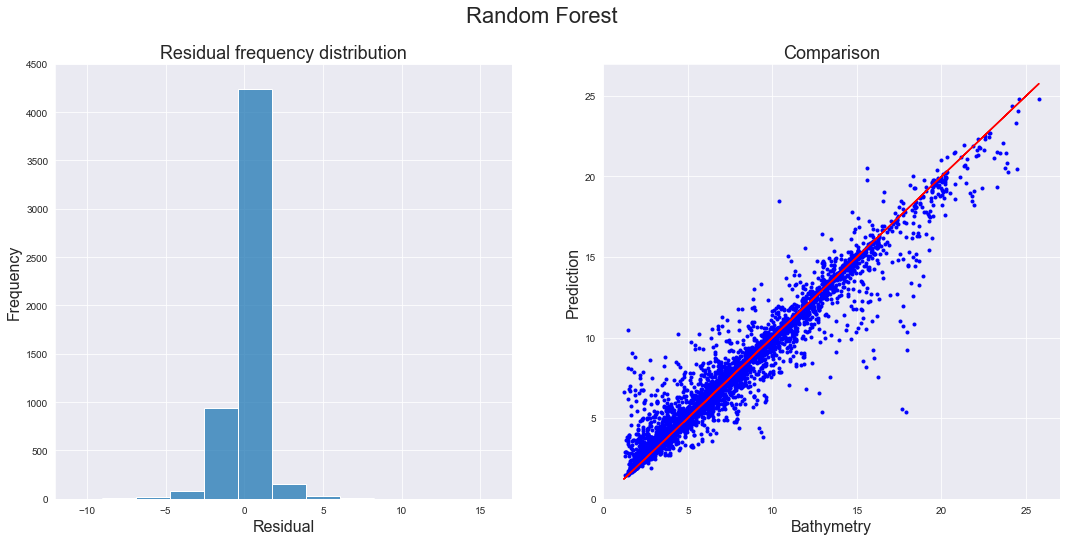

In [8]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('Random Forest',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)

sns.histplot(y_val-p_rf, bins=10,ax=axs[0])
axs[1].plot(y_val,p_rf,'b.',y_val,y_val,'r')
plt.savefig('generated/charts/RF.jpg')

# 2.0 - XGBoost

In [9]:
xg = XGBRegressor()
xg.fit(X_train, y_train)
p_xg = xg.predict(X_val)
print('XGBoost Bands:')
print('R2 score:', r2_score(y_val, p_xg))
print('Mean Absolute Error:', mean_absolute_error(y_val, p_xg))
print('Mean Squared Error:', mean_squared_error(y_val, p_xg))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, p_xg)))
print('Bias:', p_xg.mean() - y_val.mean())

XGBoost Bands:
R2 score: 0.9113324866743583
Mean Absolute Error: 0.8632484611379012
Mean Squared Error: 1.7887790170634044
Root Mean Squared Error: 1.3374524354396324
Bias: 0.04071945245236197


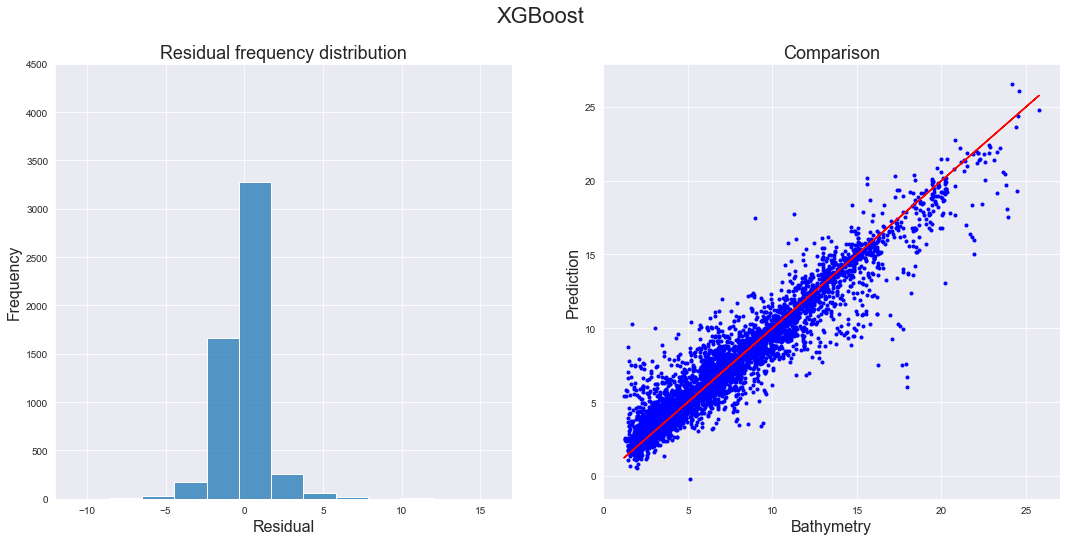

In [10]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('XGBoost',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-p_xg, bins=10,ax=axs[0])
axs[1].plot(y_val,p_xg,'b.',y_val,y_val,'r')
plt.savefig('generated/charts/XGBoost.jpg')

# 3.0 - LGBM

In [11]:
args_lgbm = [0.06189835094365267, 9, 1, 0.8695551533271082, 0.6534274736020848, 976, 2, 1]
lr = args_lgbm[0]
max_depth = args_lgbm[1]
min_child_samples = args_lgbm[2]
subsample = args_lgbm[3]
colsample_bytree = args_lgbm[4]
n_estimators = args_lgbm[5]

lgbm = LGBMRegressor(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth,
                    min_child_samples=min_child_samples, subsample=subsample,
                    colsample_bytree=colsample_bytree, bagging_freq=1, n_estimators=n_estimators,
                    random_state=0, class_weight='balanced', n_jobs=6)

lgbm.fit(X_train, y_train)
p_lgbm = lgbm.predict(X_val)

print('LGBM Bands:')
print('R2 score:', r2_score(y_val, p_lgbm))
print('Mean Absolute Error:', mean_absolute_error(y_val, p_lgbm))
print('Mean Squared Error:', mean_squared_error(y_val, p_lgbm))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, p_lgbm)))
print('Bias:', p_lgbm.mean() - y_val.mean())

LGBM Bands:
R2 score: 0.9483985691474017
Mean Absolute Error: 0.5451373953237558
Mean Squared Error: 1.041007617080458
Root Mean Squared Error: 1.0202978080347218
Bias: 0.028880756594481305


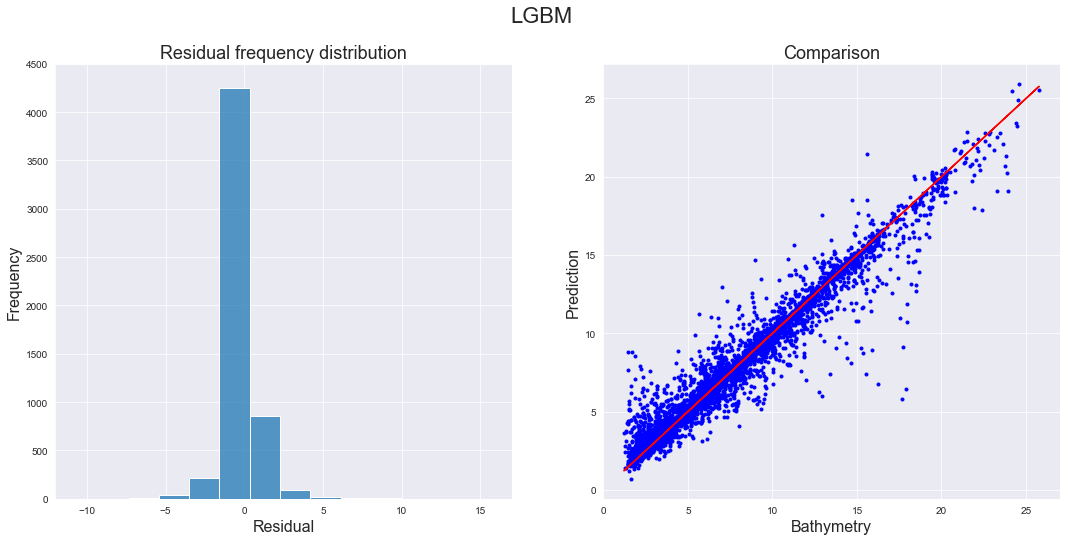

In [12]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('LGBM',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-p_lgbm, bins=10,ax=axs[0])
axs[1].plot(y_val,p_lgbm,'b.',y_val,y_val,'r')
plt.savefig('generated/charts/LGBM.jpg')

# 4.0 - MLPRegressor

In [13]:
mlp = MLPRegressor(random_state=42, max_iter=1000)
mlp.fit(X_train, y_train)
p_mlp = mlp.predict(X_val)

print('MLP Bands:')
print('R2 score:', r2_score(y_val, p_mlp))
print('Mean Absolute Error:', mean_absolute_error(y_val, p_mlp))
print('Mean Squared Error:', mean_squared_error(y_val, p_mlp))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, p_mlp)))
print('Bias:', p_mlp.mean() - y_val.mean())

MLP Bands:
R2 score: 0.49922965731894153
Mean Absolute Error: 2.3017458973957314
Mean Squared Error: 10.102544300139767
Root Mean Squared Error: 3.1784499838977753
Bias: -0.05111900608094189


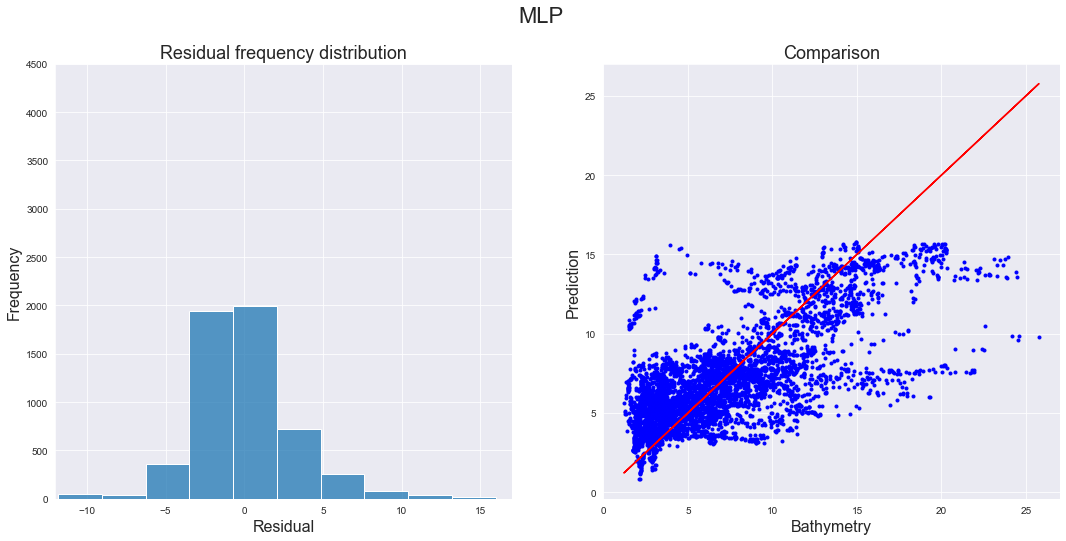

In [14]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('MLP',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-p_mlp, bins=10,ax=axs[0])
axs[1].plot(y_val,p_mlp,'b.',y_val,y_val,'r')
plt.savefig('generated/charts/MLPR.jpg')

# 5.0 - Linear Regressor

In [15]:
lr = LinearRegression()
lr.fit(X_train, y_train)
p_lr = lr.predict(X_val)

print('Linear Regression')
print('R2 score:', r2_score(y_val, p_lr))
print('Mean Absolute Error:', mean_absolute_error(y_val, p_lr))
print('Mean Squared Error:', mean_squared_error(y_val, p_lr))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, p_lr)))
print('Bias:', p_lr.mean() - y_val.mean())

Linear Regression
R2 score: 0.47908435179078646
Mean Absolute Error: 2.4851314794293233
Mean Squared Error: 10.508955830919373
Root Mean Squared Error: 3.2417519693707866
Bias: 0.04283562506765204


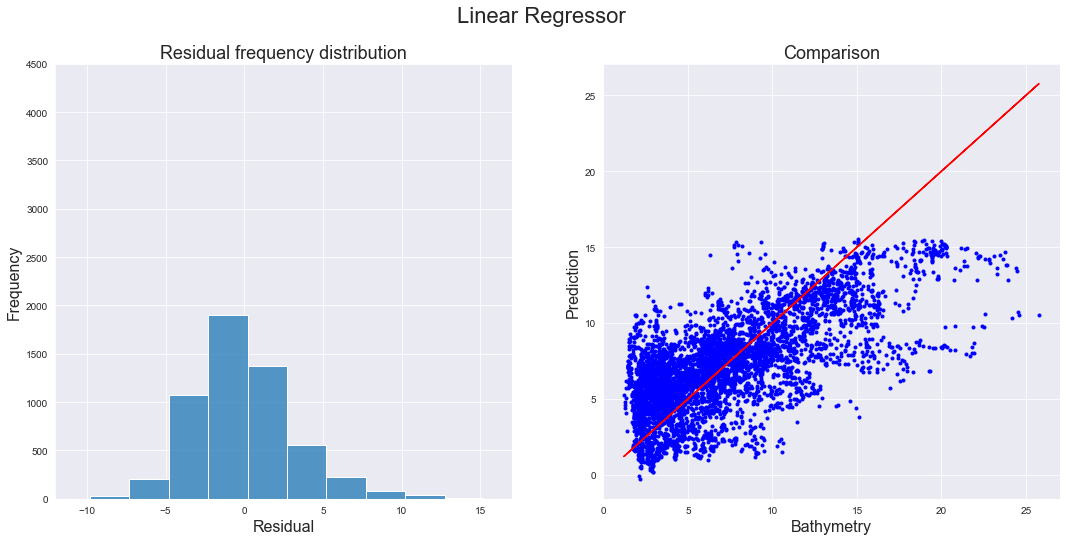

In [16]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('Linear Regressor',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-p_lr, bins=10,ax=axs[0])
axs[1].plot(y_val,p_lr,'b.',y_val,y_val,'r')
plt.savefig('generated/charts/LR.jpg')

## 5.1 Polynomial Transform

In [17]:
lr_poly = LinearRegression()
poly = PolynomialFeatures(degree=2)

In [18]:
train_data = poly.fit_transform(X_train)
val_data = poly.transform(X_val)

In [19]:
lr_poly.fit(train_data, y_train)
p_lr_poly = lr_poly.predict(val_data)

print('Polynomial Regression Bands:')
print('R2 score:', r2_score(y_val, p_lr_poly))
print('Mean Absolute Error:', mean_absolute_error(y_val, p_lr_poly))
print('Mean Squared Error:', mean_squared_error(y_val, p_lr_poly))
print('Root Mean Squared Error:', np.sqrt(mean_squared_error(y_val, p_lr_poly)))
print('Bias:', p_lr_poly.mean() - y_val.mean())

Polynomial Regression Bands:
R2 score: 0.6249267461302624
Mean Absolute Error: 2.0092593661409035
Mean Squared Error: 7.566730375304868
Root Mean Squared Error: 2.7507690516117247
Bias: 0.029257142366378552


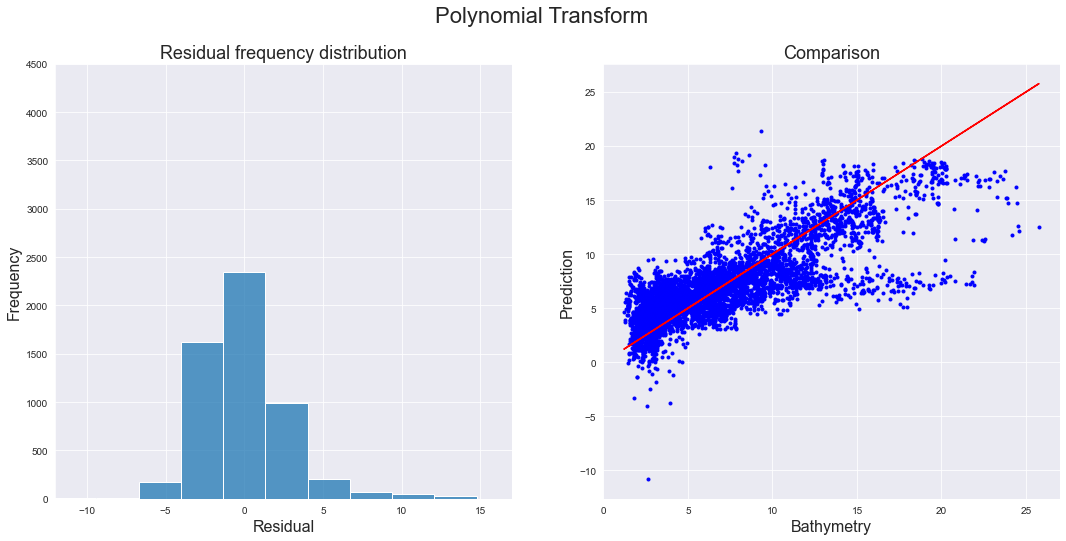

In [20]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('Polynomial Transform',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-p_lr_poly, bins=10,ax=axs[0])
axs[1].plot(y_val,p_lr_poly,'b.',y_val,y_val,'r')
plt.savefig('generated/charts/PT.jpg')

# 6 Cluster-based regression - Random Forest

In [21]:
columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']
df_c = df.reset_index(drop=True)
cluster_dict_rf = dict()
for cluster_number in range(1,11,1):
#for cluster_number in range(2,11,2):
    df_features = df_c[columns].copy()
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(df_features)
    df_features['cluster'] = kmeans.labels_

    df_dist = pd.DataFrame(kmeans.transform(df_features.drop(['cluster'],axis=1)))
    
    drop_list = list()
    for i in range(cluster_number):
        drop_list.append(f'norm_dist_to_{i}')
        
    df_dist.columns = drop_list
    for i in range(cluster_number):
        df_dist[f'norm_dist_to_{i}'] = 1/df_dist[f'norm_dist_to_{i}']
    df_dist['sum'] = df_dist.sum(axis=1)
    for i in range(cluster_number):
        df_dist[f'norm_dist_to_{i}'] = df_dist[f'norm_dist_to_{i}']/df_dist['sum']
    df_dist.drop(['sum'],axis=1,inplace=True)

    df_features = pd.concat([df_features,df_dist],axis=1)

    X_train, X_val, y_train, y_val = train_test_split(df_features, df_c['z'], test_size=0.3, random_state=42)

    
    drop_list.append('cluster')

    models = list()
    for i in range(cluster_number):
        X_train_model = X_train[X_train['cluster'] == i]
        y_train_model = y_train[y_train.index.isin(X_train_model.index)]
        X_train_model.drop(drop_list,axis=1)
        obj = RandomForestRegressor()
        obj.fit(X_train_model.drop(drop_list,axis=1), y_train_model)
        models.append(obj)

    predicts = list()
    for i in range(cluster_number):
        predict = models[i].predict(X_val.drop(drop_list,axis=1))*X_val[f'norm_dist_to_{i}']
        predicts.append(predict)

    df_predicts = pd.DataFrame(predicts).transpose()
    df_predicts['predict'] = df_predicts.sum(axis=1)

    result_dict = dict()
    result_dict['r2'] = r2_score(y_val, df_predicts['predict'])
    result_dict['mae'] = mean_absolute_error(y_val, df_predicts['predict'])
    result_dict['mse'] = mean_squared_error(y_val, df_predicts['predict'])
    result_dict['rmse'] = np.sqrt(mean_squared_error(y_val, df_predicts['predict']))
    result_dict['bias'] = df_predicts['predict'].mean() - y_val.mean()
    result_dict['prediction'] = df_predicts['predict']

    cluster_dict_rf[str(cluster_number)] = result_dict
    
for key, val in cluster_dict_rf.items():
    print(f'CBR for {key} clusters:')
    print('R2 score:', val['r2'])
    print('Mean Absolute Error:', val['mae'])
    print('Mean Squared Error:', val['mse'])
    print('Root Mean Squared Error:', val['rmse'])
    print('Bias:', val['bias'])

CBR for 1 clusters:
R2 score: 0.9424588362435354
Mean Absolute Error: 0.5424604716511456
Mean Squared Error: 1.160835829092855
Root Mean Squared Error: 1.077420915470298
Bias: 0.03310925182566926
CBR for 2 clusters:
R2 score: 0.8714943571444962
Mean Absolute Error: 1.1895187397879747
Mean Squared Error: 2.592473713229688
Root Mean Squared Error: 1.6101160558263146
Bias: 0.1414056523005227
CBR for 3 clusters:
R2 score: 0.8152681825171008
Mean Absolute Error: 1.451311913990225
Mean Squared Error: 3.7267809426864336
Root Mean Squared Error: 1.9304872293507755
Bias: 0.17519269671754056
CBR for 4 clusters:
R2 score: 0.7479977149464789
Mean Absolute Error: 1.7977535314545723
Mean Squared Error: 5.0838958131174925
Root Mean Squared Error: 2.2547496120672674
Bias: 0.7548064467442357
CBR for 5 clusters:
R2 score: 0.72629029985611
Mean Absolute Error: 1.8237423933658505
Mean Squared Error: 5.521821352832706
Root Mean Squared Error: 2.349855602549379
Bias: 0.3976797392784768
CBR for 6 clusters:
R

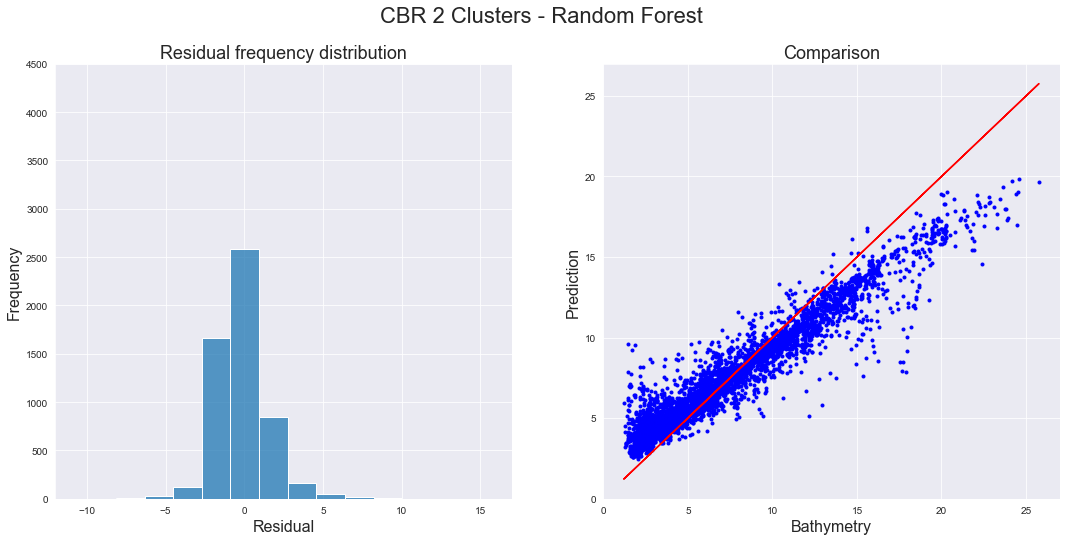

In [22]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('CBR 2 Clusters - Random Forest',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-cluster_dict_rf['2']['prediction'], bins=10,ax=axs[0])
axs[1].plot(y_val,cluster_dict_rf['2']['prediction'],'b.',y_val,y_val,'r')
plt.savefig('generated/charts/CBRRF.jpg')

# 6.1 Cluster-based regression - Polynomial regression

In [23]:
columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']
df_c = df.reset_index(drop=True)
cluster_dict_pr = dict()
for cluster_number in range(1,11,1):
#for cluster_number in range(2,11,2):
    df_features = df_c[columns].copy()
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(df_features)
    df_features['cluster'] = kmeans.labels_

    df_dist = pd.DataFrame(kmeans.transform(df_features.drop(['cluster'],axis=1)))
    
    drop_list = list()
    for i in range(cluster_number):
        drop_list.append(f'norm_dist_to_{i}')
        
    df_dist.columns = drop_list
    for i in range(cluster_number):
        df_dist[f'norm_dist_to_{i}'] = 1/df_dist[f'norm_dist_to_{i}']
    df_dist['sum'] = df_dist.sum(axis=1)
    for i in range(cluster_number):
        df_dist[f'norm_dist_to_{i}'] = df_dist[f'norm_dist_to_{i}']/df_dist['sum']
    df_dist.drop(['sum'],axis=1,inplace=True)

    df_features = pd.concat([df_features,df_dist],axis=1)

    X_train, X_val, y_train, y_val = train_test_split(df_features, df_c['z'], test_size=0.3, random_state=42)

    
    drop_list.append('cluster')

    models = list()
    for i in range(cluster_number):
        X_train_model = X_train[X_train['cluster'] == i]
        y_train_model = y_train[y_train.index.isin(X_train_model.index)]
        X_train_model.drop(drop_list,axis=1)
        
        lr_poly = LinearRegression()
        poly = PolynomialFeatures(degree=2)
        
        train_data_x = poly.fit_transform(X_train_model.drop(drop_list,axis=1))
        
        lr_poly.fit(train_data_x, y_train_model)
        models.append([lr_poly,poly])

    predicts = list()
    for i in range(cluster_number):
             
        val_data = models[i][1].transform(X_val.drop(drop_list,axis=1))

        predict = models[i][0].predict(val_data)*X_val[f'norm_dist_to_{i}']
        predicts.append(predict)

    df_predicts = pd.DataFrame(predicts).transpose()
    df_predicts['predict'] = df_predicts.sum(axis=1)

    result_dict = dict()
    result_dict['r2'] = r2_score(y_val, df_predicts['predict'])
    result_dict['mae'] = mean_absolute_error(y_val, df_predicts['predict'])
    result_dict['mse'] = mean_squared_error(y_val, df_predicts['predict'])
    result_dict['rmse'] = np.sqrt(mean_squared_error(y_val, df_predicts['predict']))
    result_dict['bias'] = df_predicts['predict'].mean() - y_val.mean()
    result_dict['prediction'] = df_predicts['predict']

    cluster_dict_pr[str(cluster_number)] = result_dict
    
for key, val in cluster_dict_pr.items():
    print(f'CBR for {key} clusters:')
    print('R2 score:', val['r2'])
    print('Mean Absolute Error:', val['mae'])
    print('Mean Squared Error:', val['mse'])
    print('Root Mean Squared Error:', val['rmse'])
    print('Bias:', val['bias'])

CBR for 1 clusters:
R2 score: 0.6249267461302624
Mean Absolute Error: 2.0092593661409035
Mean Squared Error: 7.566730375304868
Root Mean Squared Error: 2.7507690516117247
Bias: 0.029257142366556188
CBR for 2 clusters:
R2 score: 0.41144564811306594
Mean Absolute Error: 2.4207575647397044
Mean Squared Error: 11.873499499080264
Root Mean Squared Error: 3.4457944655884893
Bias: -0.467501421740109
CBR for 3 clusters:
R2 score: 0.5699567149956641
Mean Absolute Error: 2.1423836786185375
Mean Squared Error: 8.675696157392
Root Mean Squared Error: 2.945453472284361
Bias: -0.31277869283584536
CBR for 4 clusters:
R2 score: 0.03719149859827531
Mean Absolute Error: 3.031808631993668
Mean Squared Error: 19.42370525755582
Root Mean Squared Error: 4.407233288306375
Bias: -2.299160163749069
CBR for 5 clusters:
R2 score: 0.38641261417871375
Mean Absolute Error: 2.355195377346999
Mean Squared Error: 12.378516095979185
Root Mean Squared Error: 3.5183115404948415
Bias: -0.40243611946732205
CBR for 6 cluste

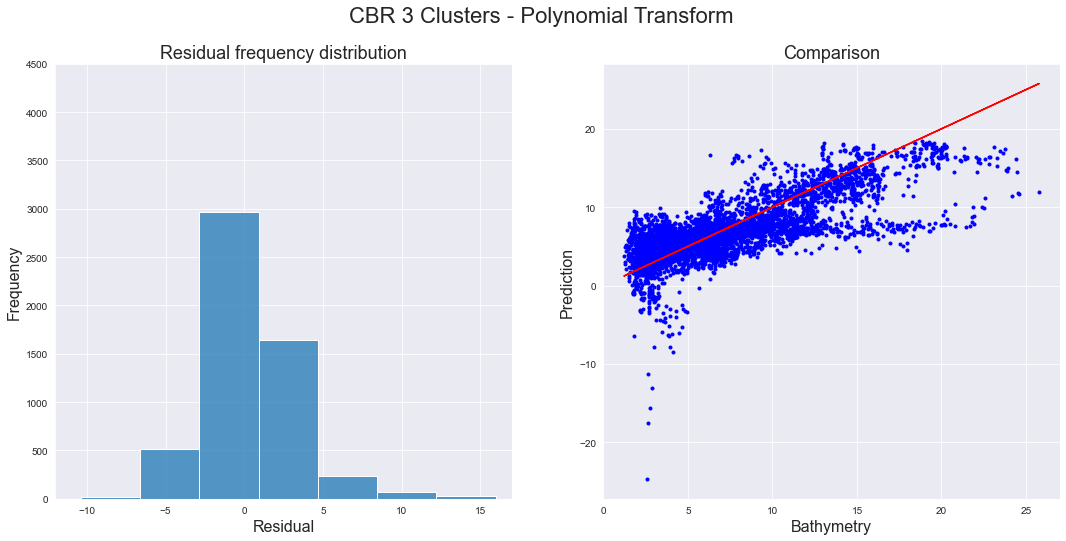

In [24]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('CBR 3 Clusters - Polynomial Transform',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-cluster_dict_pr['3']['prediction'], bins=10,ax=axs[0])
axs[1].plot(y_val,cluster_dict_pr['3']['prediction'],'b.',y_val,y_val,'r')
plt.savefig('generated/charts/CBRPT.jpg')

# 6.2 Cluster-based regression - Linear regression

In [25]:
columns = ['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'b7', 'b8']
df_c = df.reset_index(drop=True)
cluster_dict_lr = dict()
for cluster_number in range(1,11,1):
#for cluster_number in range(2,11,2):
    df_features = df_c[columns].copy()
    kmeans = KMeans(n_clusters=cluster_number, random_state=0).fit(df_features)
    df_features['cluster'] = kmeans.labels_

    df_dist = pd.DataFrame(kmeans.transform(df_features.drop(['cluster'],axis=1)))
    
    drop_list = list()
    for i in range(cluster_number):
        drop_list.append(f'norm_dist_to_{i}')
        
    df_dist.columns = drop_list
    for i in range(cluster_number):
        df_dist[f'norm_dist_to_{i}'] = 1/df_dist[f'norm_dist_to_{i}']
    df_dist['sum'] = df_dist.sum(axis=1)
    for i in range(cluster_number):
        df_dist[f'norm_dist_to_{i}'] = df_dist[f'norm_dist_to_{i}']/df_dist['sum']
    df_dist.drop(['sum'],axis=1,inplace=True)

    df_features = pd.concat([df_features,df_dist],axis=1)

    X_train, X_val, y_train, y_val = train_test_split(df_features, df_c['z'], test_size=0.3, random_state=42)

    
    drop_list.append('cluster')

    models = list()
    for i in range(cluster_number):
        X_train_model = X_train[X_train['cluster'] == i]
        y_train_model = y_train[y_train.index.isin(X_train_model.index)]
        X_train_model.drop(drop_list,axis=1)
        
        lr = LinearRegression()       
        lr.fit(X_train_model.drop(drop_list,axis=1), y_train_model)
        models.append(lr)

    predicts = list()
    for i in range(cluster_number):
        
        predict = models[i].predict(X_val.drop(drop_list,axis=1))*X_val[f'norm_dist_to_{i}']
        predicts.append(predict)

    df_predicts = pd.DataFrame(predicts).transpose()
    df_predicts['predict'] = df_predicts.sum(axis=1)

    result_dict = dict()
    result_dict['r2'] = r2_score(y_val, df_predicts['predict'])
    result_dict['mae'] = mean_absolute_error(y_val, df_predicts['predict'])
    result_dict['mse'] = mean_squared_error(y_val, df_predicts['predict'])
    result_dict['rmse'] = np.sqrt(mean_squared_error(y_val, df_predicts['predict']))
    result_dict['bias'] = df_predicts['predict'].mean() - y_val.mean()
    result_dict['prediction'] = df_predicts['predict']

    cluster_dict_lr[str(cluster_number)] = result_dict
    
for key, val in cluster_dict.items():
    print(f'CBR for {key} clusters:')
    print('R2 score:', val['r2'])
    print('Mean Absolute Error:', val['mae'])
    print('Mean Squared Error:', val['mse'])
    print('Root Mean Squared Error:', val['rmse'])
    print('Bias:', val['bias'])

NameError: name 'cluster_dict' is not defined

In [ ]:
fig,axs = plt.subplots(ncols=2,figsize=(18,8))
fig.suptitle('CBR 4 Clusters - Linear Regression',fontsize=22)
axs[0].set_title('Residual frequency distribution',fontsize=18)
axs[0].set_xlabel('Residual',fontsize=16)
axs[0].set_ylabel('Frequency',fontsize=16)
axs[0].set_xlim((-12, 17))
axs[0].set_ylim((0, 4500))
axs[1].set_title('Comparison',fontsize=18)
axs[1].set_xlabel('Bathymetry',fontsize=16)
axs[1].set_ylabel('Prediction',fontsize=16)
sns.histplot(y_val-cluster_dict_lr['4']['prediction'], bins=10,ax=axs[0])
axs[1].plot(y_val,cluster_dict_lr['4']['prediction'],'b.',y_val,y_val,'r')
plt.savefig('generated/charts/CBRLR.jpg')